In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import json
import geopandas as gpd
from copy import deepcopy
import shapely
from shapely.geometry import Point,Polygon,LineString
import pyproj

### map of the 50 metro areas

In [35]:
# shape file for US metro areas
metromap = gpd.read_file("../data/shapes/tl_2019_us_cbsa/tl_2019_us_cbsa.shp")

In [36]:
# manipulations
metromap.set_geometry("geometry",inplace=True)

metromap["GEOID"] = metromap["GEOID"].astype(int)

In [37]:
# cbsa info table
cbsa_info = pd.read_csv("../data/cbsacode_shortname_tracts.csv", sep=";", index_col=0)

In [38]:
# manipulations
cbsa_info = cbsa_info.loc[:,["cbsacode", "short_name"]].drop_duplicates()
cbsa_info["selected"] = 1
cbsa_info["color"] = "green"

In [39]:
# merge for plot
metromap = pd.merge(metromap, cbsa_info, left_on="GEOID", right_on="cbsacode", how="left")

In [40]:
# correction on the final dataframe
metromap["selected"] = metromap["selected"].fillna(0)
metromap["color"] = metromap["color"].fillna("lightgray")

/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


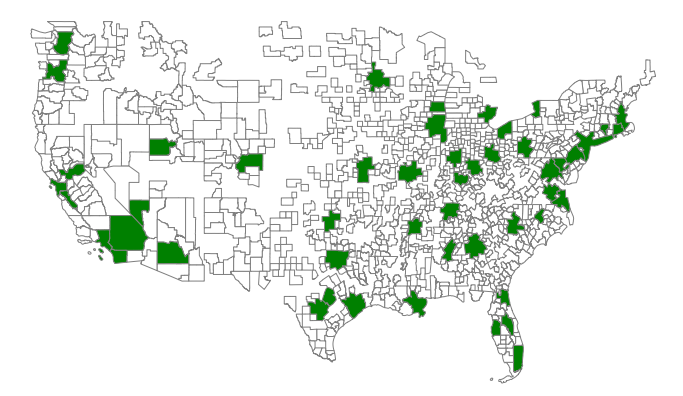

In [16]:
# map creation
fig, ax = plt.subplots(figsize = (12,12))

metromap.plot(ax=ax, column="selected", color=metromap["color"], edgecolor='gray')
plt.xlim([-127,-66])
plt.ylim([24,50])
plt.axis('off')
plt.show()
# plt.savefig("../fig/map_50metros.png", dpi=600, bbox_inches='tight')

In [41]:
# shape file for US states
usmap = gpd.read_file("../data/shapes/tl_2017_us_state/tl_2017_us_state.shp")

# manipulations
usmap.set_geometry("geometry",inplace=True)

/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


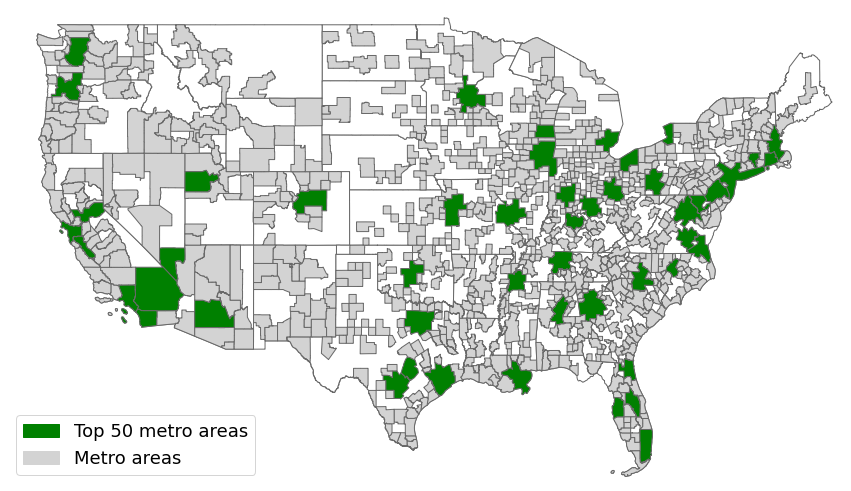

In [55]:
# map upgrade

import matplotlib.patches as mpatches
plt.rcParams['font.size']=18
fig, ax = plt.subplots(figsize = (15,15))

usmap.plot(ax=ax, color="white", edgecolor='dimgray')
metromap.plot(ax=ax, column="selected", color=metromap["color"], edgecolor='dimgray')
plt.xlim([-127,-66])
plt.ylim([24,50])
plt.axis('off')

top50metro = mpatches.Patch(color='green', label='Top 50 metro areas')
allmetro = mpatches.Patch(color='lightgray', label='Metro areas')
ax.legend(handles=[top50metro, allmetro], loc='lower left')

# plt.show()
plt.savefig("../fig/map_50metros.png", dpi=600, bbox_inches='tight')